# CMR Measures EDA and Classification with Logistic Regression (baseline)

Is it possible to detect differences in cardiac measures between patients with diabetes / hypertension?

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
heart= pd.read_csv("heart_disease.csv")
print(heart.head())

cmr_vars= ["cmr_LVEDV_i", "cmr_LVESV_i", "cmr_LVM_i", "cmr_LVEF", "cmr_RVEF", "cmr_RVEDV_i", "cmr_RVESV_i"]

   sex  ethnicity  diabetes  hyperten  highchol  prevMI  smok_status  \
0    0          0         1         1         1       0            0   
1    0          0         0         0         0       0            1   
2    1          0         0         0         0       0            0   
3    0          0         0         0         0       0            1   
4    0          1         0         0         1       0            1   

    cmr_LVEF  smokerCurrent      age_5       bsa     bmi_5  cmr_LVEDV_i  \
0  64.465409              0  12.733196  1.744422  5.562500    73.012494   
1  59.775877              0  14.282820  1.739263  5.156385    65.073337   
2  63.243244              0  14.483231  2.139494  5.872084    80.808893   
3  52.413793              0  12.049829  1.831942  5.826339    52.835628   
4  66.229023              0  14.133333  1.853893  5.991946    78.246369   

   cmr_LVESV_i  cmr_LVM_i  asi_combined   cmr_RVEF  cmr_RVEDV_i  cmr_RVESV_i  
0    25.944691  43.816107      11.594

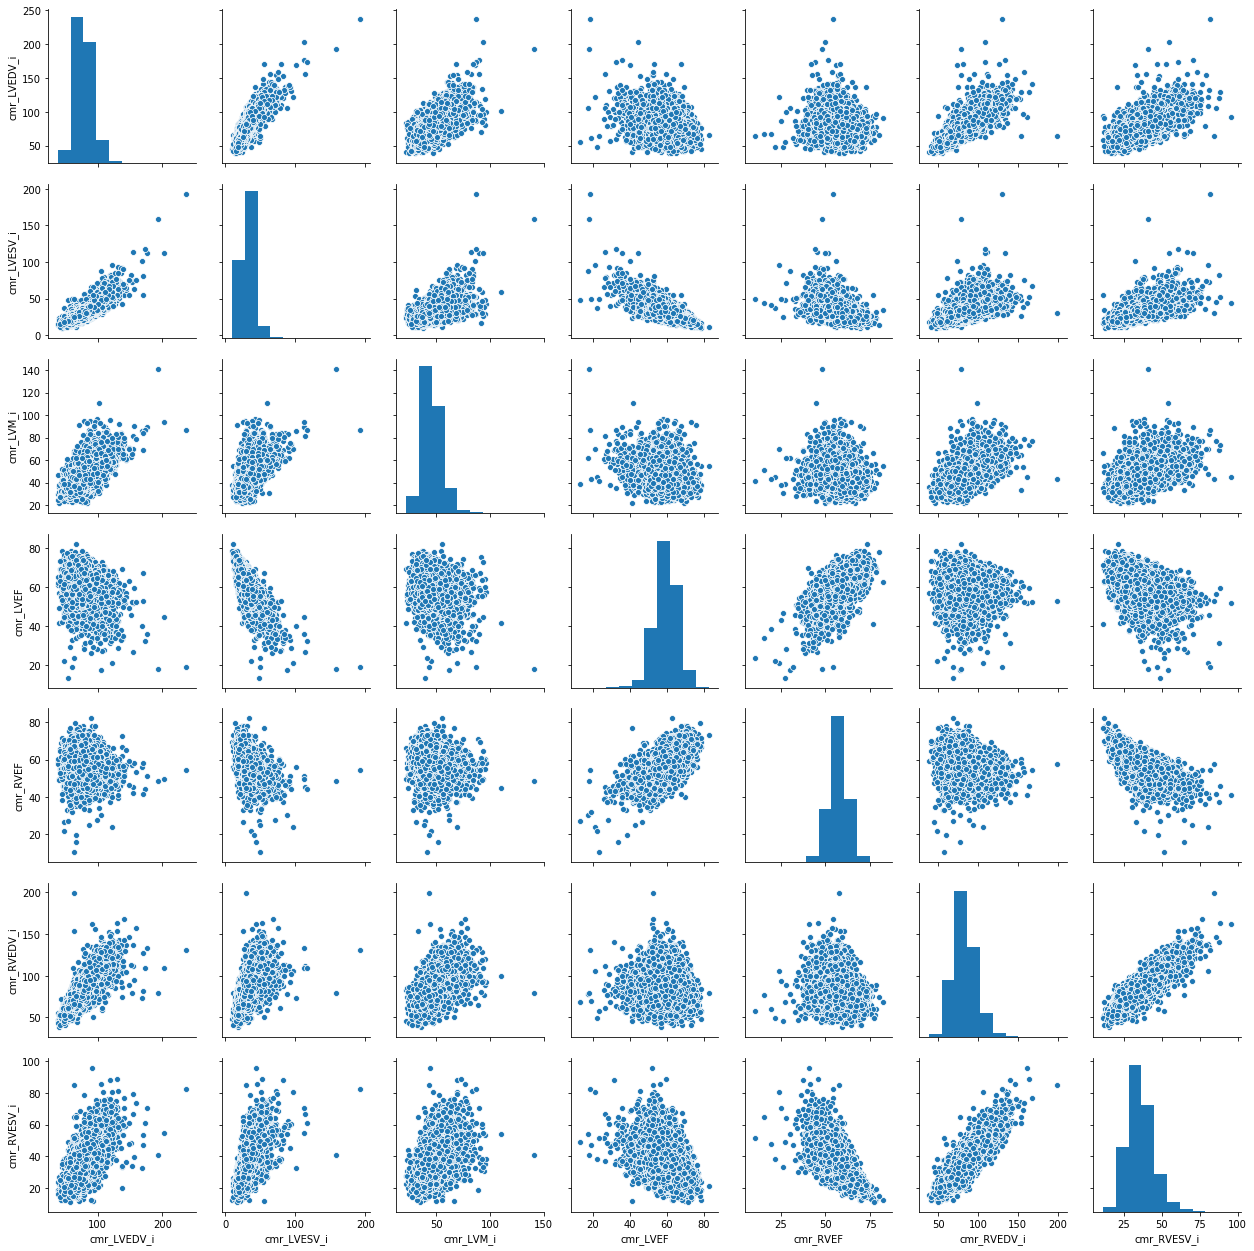

In [12]:
sns.pairplot(data=heart,
        vars=cmr_vars,
        kind='scatter')

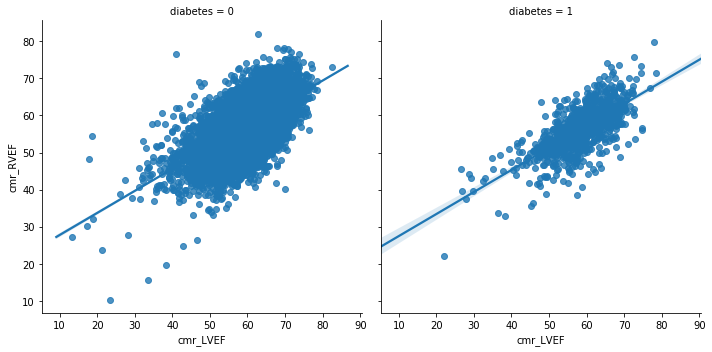

In [6]:
# Create a regression plot using hue
sns.lmplot(data=heart,
           x="cmr_LVEF",
           y="cmr_RVEF",
           col="diabetes")

# Show the results
plt.show()

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA


# Create a scaler
scaler = StandardScaler()
pca = PCA()

pipeline= make_pipeline(scaler, pca)
pipeline.fit(heart[cmr_vars])

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False))],
         verbose=False)

([<matplotlib.axis.XTick at 0x1331e2090>,
 <a list of 7 Text xticklabel objects>)

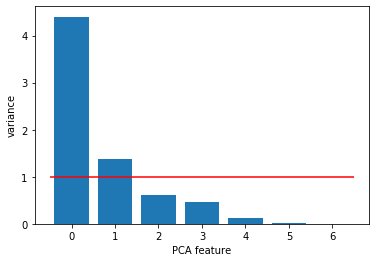

In [19]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.hlines(y= 1, xmin= -0.5, xmax= 6.5, colors= "red")
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)

In [21]:
pca = PCA(n_components = 2)

pipeline= make_pipeline(scaler, pca)
features= pipeline.fit_transform(heart[cmr_vars])
print(features.shape)

In [24]:
heart['pc1']= features[:,0]
heart['pc2']= features[:,1]

In [28]:
pca.components_.T * np.sqrt(pca.explained_variance_)

array([[ 0.84364944, -0.42929102],
       [ 0.91631128,  0.10223246],
       [ 0.73645303, -0.28575049],
       [-0.59966163, -0.70103684],
       [-0.61526452, -0.65485998],
       [ 0.83974375, -0.43016918],
       [ 0.92887615,  0.01816288]])

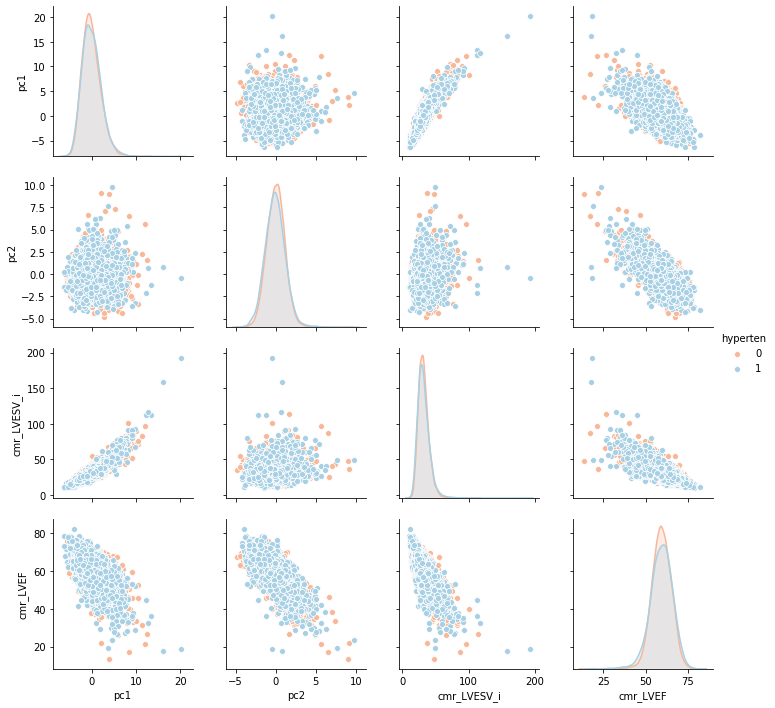

In [30]:
sns.pairplot(data=heart,
        vars=["pc1", "pc2", "cmr_LVESV_i", "cmr_LVEF"],
        kind='scatter',
        hue='hyperten',
        palette='RdBu')

In [46]:

from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV

y=  heart.hyperten.values
X=  heart[["pc1","pc2"]].values

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify= y)


In [48]:
# Apply logistic regression and print scores
lr = LogisticRegression(solver= "lbfgs")
lr.fit(X_train, y_train)
#print(lr.score(X_train,y_train))
print(lr.score(X_test,y_test))

# Apply SVM and print scores
svm = SVC(gamma= "auto")
svm.fit(X_train, y_train)
#print(svm.score(X_train, y_train))
print(svm.score(X_test, y_test))

from sklearn.neighbors import KNeighborsClassifier

# Create and fit the model
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print(knn.score(X_test, y_test))

0.6817807089859852
0.6793075020610058
0.6143858202802968


In [49]:
y=  heart.hyperten.values
X=  heart[["pc1","pc2","sex", "ethnicity", "diabetes", "smokerCurrent", "age_5", "bmi_5"]].values

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify= y)

In [50]:
# Apply logistic regression and print scores
lr = LogisticRegression(solver= "lbfgs")
lr.fit(X_train, y_train)
#print(lr.score(X_train,y_train))
print(lr.score(X_test,y_test))

# Apply SVM and print scores
svm = SVC(gamma= "auto")
svm.fit(X_train, y_train)
#print(svm.score(X_train, y_train))
print(svm.score(X_test, y_test))

from sklearn.neighbors import KNeighborsClassifier

# Create and fit the model
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print(knn.score(X_test, y_test))

0.7176422093981863
0.7137262984336357
0.6848722176422094


In [62]:
# Specify L1 regularization
lr = LogisticRegression(penalty= 'l1', solver= "saga")

# Instantiate the GridSearchCV object and run the search
searcher = GridSearchCV(lr, {'C':[0.001, 0.01, 0.1, 1, 10]})
searcher.fit(X_train, y_train)

# Report the best parameters
print("Best CV params", searcher.best_params_)

# Find the number of nonzero coefficients (selected features)
best_lr = searcher.best_estimator_
coefs = best_lr.coef_
print("Total number of features:", coefs.size)
print("Number of selected features:", np.count_nonzero(coefs))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter wa

Best CV params {'C': 0.1}
Total number of features: 8
Number of selected features: 7


In [53]:
# Instantiate an RBF SVM
svm = SVC()

# Instantiate the GridSearchCV object and run the search
parameters = {'C':[0.1, 1, 10], 'gamma':[0.00001, 0.0001, 0.001, 0.01, 0.1]}
searcher = GridSearchCV(svm, param_grid= parameters)
searcher.fit(X_train, y_train)

# Report the best parameters and the corresponding score
print("Best CV params", searcher.best_params_)
print("Best CV accuracy", searcher.best_score_)

# Report the test accuracy using these best parameters
print("Test accuracy of best grid search hypers:", searcher.score(X_test, y_test))


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best CV params {'C': 1, 'gamma': 0.1}
Best CV accuracy 0.7217259859832349
Test accuracy of best grid search hypers: 0.7118713932399011


In [58]:
from sklearn.metrics import classification_report, confusion_matrix

# Calculate predictions: predictions
lr = LogisticRegression(solver= "lbfgs")
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)

print(confusion_matrix(y_test, predictions))

# Create the performance report
print(classification_report(y_test, predictions))

[[3044  264]
 [1106  438]]
              precision    recall  f1-score   support

           0       0.73      0.92      0.82      3308
           1       0.62      0.28      0.39      1544

    accuracy                           0.72      4852
   macro avg       0.68      0.60      0.60      4852
weighted avg       0.70      0.72      0.68      4852



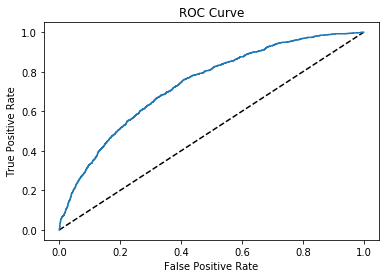

In [61]:
# Import necessary modules
from sklearn.metrics import roc_curve

# Compute predicted probabilities: y_pred_prob
y_pred_prob = lr.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [64]:
y=  heart.hyperten.values
X=  heart[["sex", "ethnicity", "diabetes", "smokerCurrent", "age_5", "bmi_5"]].values

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify= y)

lr = LogisticRegression(solver= "lbfgs")
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.7184666117065128